## Lecture 5 - Convolutional neural networks

> A deep dive into convolutional neural networks for jet tagging

## Learning objectives

* Know how to implement and train a convolutional neural network in PyTorch
* Understand what the 1-cycle training policy is
* Understand batch norm

## References

* Chapter 13 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.

## Setup

In [ ]:
# Uncomment and run this cell if using Colab, Kaggle etc
# %pip install fastai==2.6.0 datasets

## Imports

In [1]:
from datasets import load_dataset
from fastai.vision.all import *
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset
from torchvision.transforms import ToTensor

In [2]:
import datasets

# Suppress logs to keep things tidy
datasets.logging.set_verbosity_error()

## Loading the data

Last lecture we fine-tuned a pretrained CNN on the top tagging dataset, where each jet was represented as a 2D image of "energy pixels". Today, we'll take a look at training our own CNN from scratch, and explore some of the techniques that fastai utilizes to stabilise the training of these neural nets. To get started, let's download the same dataset of jet images from last lecture:

  0%|          | 0/3 [00:00<?, ?it/s]

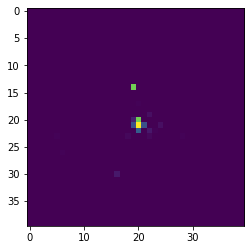

In [3]:
images_ds = load_dataset("dl4phys/top_tagging_images")

# Peek at one example
plt.imshow(images_ds["train"][0]["image"]);

As we saw last lecture, we need to convert these PIL images into PyTorch tensors, so let's reuse the same helper function to create a training and validation set to experiment with:

In [4]:
def get_dataset(dataset, num_examples=None):
    if num_examples is not None:
        dataset = dataset.shuffle(seed=42).select(range(num_examples))

    x = torch.cat([ToTensor()(img) for img in dataset["image"]]).unsqueeze(1)
    y = torch.cat([torch.tensor(l).unsqueeze(0) for l in dataset["label"]])

    return TensorDataset(x, y)

With this function, we can now generate a sample of jets as follows:

In [5]:
# Lower the training size if Colab RAM explodes 💣
train_ds = get_dataset(images_ds["train"], num_examples=350_000)
valid_ds = get_dataset(images_ds["validation"], num_examples=35_000)

Since we'll be experimenting a bit with the batch size in this lecture, we'll also implement a helper function to return the dataloaders associated with these datasets:

In [6]:
def get_dls(bs=128):
    train_dl = DataLoader(train_ds, bs=bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, bs=bs)
    return DataLoaders(train_dl, valid_dl)

Now that we have this function, we can get the dataloaders and grab a batch of data to test with:

In [7]:
dls = get_dls()

xb, yb = first(dls.train)
xb.shape, yb.shape

(torch.Size([128, 1, 40, 40]), torch.Size([128]))

## Creating a CNN

Recall in lecture 3, that we created a neural network for $N$-subjettiness features. We used the `nn.Sequential()` class to create a network that involved stacking fully-connected layers and ReLU activation functions:

In [10]:
model = nn.Sequential(
    nn.Linear(20, 200),
    nn.ReLU(),
    nn.Linear(200, 2),
)

model

Sequential(
  (0): Linear(in_features=20, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=2, bias=True)
)

In this lecture, we'll take a similar approach, but this time using _convolutional layers_ instead of linear ones. In PyTorch, convolutional layers are created by using the `nn.Conv2d()` module. Let's try replacing the `nn.Linear()` layers in our previous architecture with `nn.Conv2d()` ones instead:

In [13]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1),
)

Note that unlike linear layers, convolutional layers don't require us to specify the number of features in the input. That's because convolutions are applied across each pixel automatically, so the weights only depend on the number of channels and the kernel size. 

Let's now see what happens if we pass a minibatch of data through this model:

In [15]:
# Feed a minibatch to the model
outputs = broken_cnn(xb)
outputs.shape

torch.Size([128, 1, 40, 40])

Hmm, this output isn't quite what we want for classification: we need a tensor of shape `(batch_size, num_classes)` but instead have a $40\times 40$ map of activations. The standard way to handle this is to apply a sequence of _stride-2 convolutions_, which decrease the size of the outputs so that the final layer size is 1. To see why this is the case, recall that for an image of height $n_H$ and width $n_W$, the dimension of the output activation map is given by:

$$\left( \left\lfloor\frac{n_H + 2p - k}{s} + 1 \right\rfloor ,  \left\lfloor\frac{n_W + 2p - k}{s} + 1 \right\rfloor \right) \,,$$

where $p$ is the padding, $k$ the kernel of size $k\times k$, and $s$ the stride. For fixed $p,f$ and $s>1$, we can see that the dimension of the activation map is shrunk with each convolutional layer.

With this in mind, let's create a stack of stride-2 convolutional layers with $3\times 3$ kernels.

In [16]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks // 2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [60]:
simple_cnn = nn.Sequential(
    conv(1, 4),  # 20x20
    conv(4, 8),  # 10x10
    conv(8, 16),  # 5x5
    conv(16, 32),  # 3x3
    conv(32, 16),  # 2x2
    conv(16, 2, act=False),  # 1x1
    Flatten(),
)

In [61]:
simple_cnn(xb).shape

torch.Size([128, 2])

In [62]:
learn = Learner(
    dls, simple_cnn, metrics=[accuracy, RocAucBinary()], loss_func=F.cross_entropy
)

In [63]:
learn.summary()

Sequential (Input shape: 128 x 1 x 40 x 40)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 4 x 20 x 20   
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 8 x 10 x 10   
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 5 x 5    
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 3 x 3    
Conv2d                                    4640       True      
ReLU                                         

In [64]:
learn.model.to("cuda");

SuggestedLRs(valley=0.0012022644514217973)

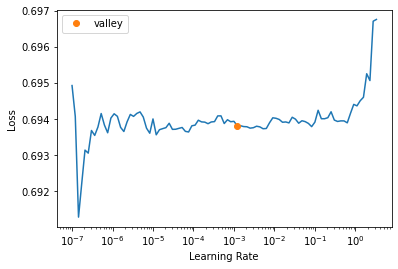

In [65]:
learn.lr_find()

In [66]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.290375,0.293057,0.873886,0.947308,00:10
1,0.254559,0.252380,0.894314,0.959527,00:10
2,0.233504,0.246849,0.898086,0.961033,00:10


## Improving training stability

In [67]:
def simple_cnn():
    return nn.Sequential(
        conv(1, 8, ks=5),  # 20x20
        conv(8, 16),  # 10x10
        conv(16, 32),  # 5x5
        conv(32, 64),  # 3x3
        conv(64, 128),  # 2x2
        conv(128, 2, act=False),  # 1x1
        Flatten(),
    ).to("cuda")

In [68]:
from fastai.callback.hook import *

In [69]:
def fit(epochs=1):
    learn = Learner(
        dls,
        simple_cnn(),
        metrics=[accuracy, RocAucBinary()],
        loss_func=F.cross_entropy,
        cbs=ActivationStats(with_hist=True),
    )
    learn.fit(epochs, 0.06)
    return learn

In [70]:
learn = fit()

/home/lewis/miniconda3/envs/dl4phys/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.694316,0.693301,0.500343,0.500000,00:19


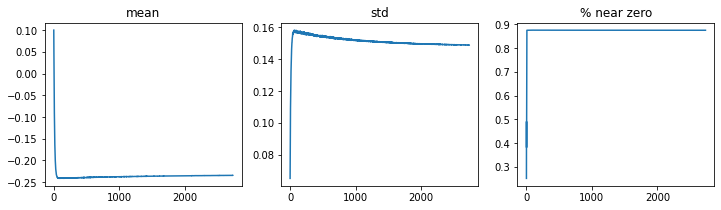

In [71]:
learn.activation_stats.plot_layer_stats(0)

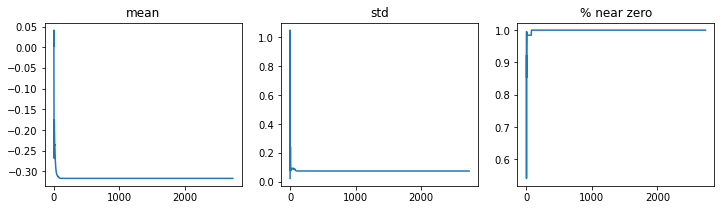

In [72]:
learn.activation_stats.plot_layer_stats(-2)

### Increase batch size

In [73]:
dls = get_dls(512)

In [ ]:
learn = fit()

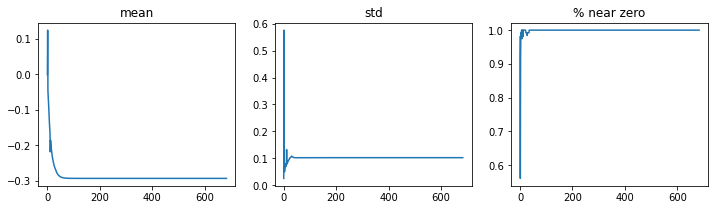

In [75]:
learn.activation_stats.plot_layer_stats(-2)

### One-cycle training

In [77]:
def fit(epochs=1, lr=0.06):
    learn = Learner(
        dls,
        simple_cnn(),
        metrics=[accuracy, RocAucBinary()],
        loss_func=F.cross_entropy,
        cbs=ActivationStats(with_hist=True),
    )
    learn.fit_one_cycle(epochs, lr)
    return learn

In [78]:
learn = fit()

/home/lewis/miniconda3/envs/dl4phys/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.255303,0.255807,0.895400,0.958187,00:12


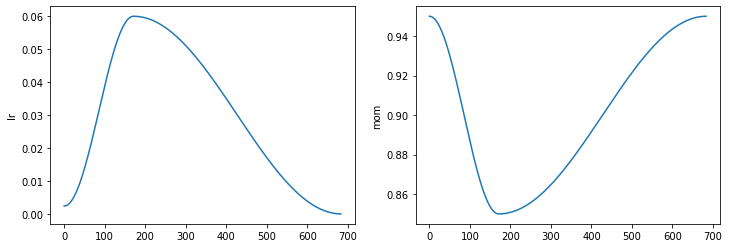

In [79]:
learn.recorder.plot_sched()

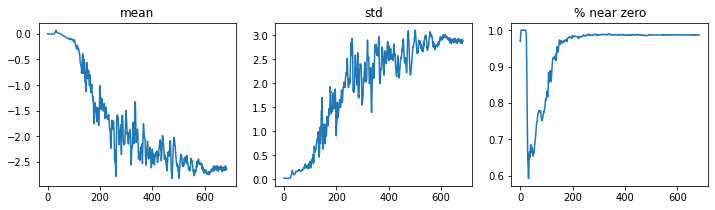

In [80]:
learn.activation_stats.plot_layer_stats(-2)

### Batch normalization

In [82]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks // 2)]
    layers.append(nn.BatchNorm2d(nf))
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [85]:
learn = fit()

/home/lewis/miniconda3/envs/dl4phys/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.215361,0.215348,0.909914,0.970373,00:22


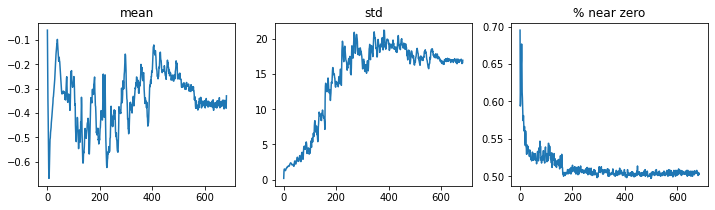

In [86]:
learn.activation_stats.plot_layer_stats(-2)

In [87]:
learn = fit(10, lr=0.1)

/home/lewis/miniconda3/envs/dl4phys/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.241621,0.324524,0.879571,0.951736,00:22
1,0.232091,1.657844,0.655914,0.913255,00:21
2,0.222661,0.819799,0.612086,0.906052,00:21
3,0.220339,0.276002,0.885429,0.957145,00:21
4,0.217905,0.410375,0.813257,0.920187,00:21
5,0.209055,0.433610,0.802971,0.920204,00:21
6,0.204782,0.363477,0.832943,0.945951,00:21
7,0.198509,0.206748,0.913429,0.972911,00:21
8,0.191656,0.202564,0.916000,0.974434,00:21
9,0.182151,0.196292,0.918886,0.975237,00:21


## Exercises

* Implement the same CNN architecture from the review. Can you get close to their results?